# Plot 2: model performance by state 


Project : Predicting Monthly Electricity Consumption 

Analysis procedure: after [notebook](https://github.com/worasom/energy_sale_rev/blob/master/energy-ML.ipynb), I obtained are three trained ML models and three csv files with the features and the corresponding importance. I use these models to predict the total electricity consumption by state. Then analyze the model performance by state, and look at the time series prediction.


In [33]:
# import the library
import sys
import feather
import pickle
from pathlib import Path
sys.path.append(r'C:\Users\Benny\fastai\old')

%config IPCompleter.greedy=True
%load_ext autoreload
%matplotlib inline

from fastai.imports import *
from fastai.structured import *
from fastai.io import *
from fastai.dataset import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *


from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.metrics import (classification_report, confusion_matrix,
accuracy_score, log_loss, mean_squared_error, mean_absolute_error, r2_score)
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import TimeSeriesSplit, KFold
import matplotlib.dates as mdates

from IPython.display import display
import seaborn as sns
import folium

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
def do_prediction(combine,m,fi_cols,pre_col,split=0.85):
    ''' Input
    combine: dataframe with all data
    fi_cols: columns to use for the model 
    m: trained model 
    split: percent data for test set 
    return y_predict and r-square 
    '''
    df, y, nas = proc_df(combine, pre_col,skip_flds=['Year-Month'], max_n_cat=49)
    df = df[fi_cols]
    X_trn,y_trn,X_test,y_test = two_split(df,y)
    
    y_predict = m.predict(X_test)
    score = m.score(X_test,y_test)
    return (y_predict, score)

In [20]:
def two_split(df,y):
    '''split data into train, validation and test 
    this is a time series data, thus no shuffle
    '''
    test_idxs = int(df.shape[0]*0.85)
    X_test = df.iloc[test_idxs:]
    y_test = y[test_idxs:]
    
    X_trn = df.iloc[:test_idxs]
    y_trn = y[:test_idxs]
    
    return (X_trn,y_trn,X_test,y_test)

In [45]:
cleanfolder = 'E:/Users/Fern/energy_data/clean/'
mfolder = 'E:/Users/Fern/energy_data/'
us_state_abbrev = {
    'Alabama': 'AL',
    'Alaska': 'AK',
    'Arizona': 'AZ',
    'Arkansas': 'AR',
    'California': 'CA',
    'Colorado': 'CO',
    'Connecticut': 'CT',
    'District of Columbia':'DC',
    'Delaware': 'DE',
    'Florida': 'FL',
    'Georgia': 'GA',
    'Hawaii': 'HI',
    'Idaho': 'ID',
    'Illinois': 'IL',
    'Indiana': 'IN',
    'Iowa': 'IA',
    'Kansas': 'KS',
    'Kentucky': 'KY',
    'Louisiana': 'LA',
    'Maine': 'ME',
    'Maryland': 'MD',
    'Massachusetts': 'MA',
    'Michigan': 'MI',
    'Minnesota': 'MN',
    'Mississippi': 'MS',
    'Missouri': 'MO',
    'Montana': 'MT',
    'Nebraska': 'NE',
    'Nevada': 'NV',
    'New Hampshire': 'NH',
    'New Jersey': 'NJ',
    'New Mexico': 'NM',
    'New York': 'NY',
    'North Carolina': 'NC',
    'North Dakota': 'ND',
    'Ohio': 'OH',
    'Oklahoma': 'OK',
    'Oregon': 'OR',
    'Pennsylvania': 'PA',
    'Rhode Island': 'RI',
    'South Carolina': 'SC',
    'South Dakota': 'SD',
    'Tennessee': 'TN',
    'Texas': 'TX',
    'Utah': 'UT',
    'Vermont': 'VT',
    'Virginia': 'VA',
    'Washington': 'WA',
    'West Virginia': 'WV',
    'Wisconsin': 'WI',
    'Wyoming': 'WY'
}

In [21]:
cleanfolder = 'E:/Users/Fern/energy_data/clean/'
mfolder = 'E:/Users/Fern/energy_data/'
# load the data 
combine = pd.read_csv(cleanfolder+'combine.csv').dropna()
combine['Year-Month'] = pd.to_datetime(combine['Year-Month'])
# set State and Regions columns as category 
combine['State'] = combine['State'].astype('category')
combine['Regions'] = combine['Regions'].astype('category')

In [22]:
# load model
m_res = pickle.load(open('model/res_model.pkl', 'rb'))
m_ind = pickle.load(open('model/ind_model.pkl', 'rb'))
m_com = pickle.load(open('model/com_model.pkl', 'rb'))

In [34]:
# load feature of importance 
fi_res = pd.read_csv('model/res_feature_importance.csv')
fi_ind = pd.read_csv('model/ind_feature_importance.csv')
fi_com = pd.read_csv('model/com_feature_importance.csv')

In [35]:
combine.columns

Index(['Year', 'Month', 'State', 'Sale_RES', 'Sale_COM', 'Sale_IND',
       'Sale_OTH', 'Sale_ALL', 'Price_RES', 'Price_COM', 'Price_IND',
       'Price_OTH', 'Price_ALL', 'Rev_RES', 'Rev_COM', 'Rev_IND', 'Rev_OTH',
       'Rev_ALL', 'Cus_RES', 'Cus_COM', 'Cus_IND', 'Cus_OTH', 'Cus_ALL',
       'Heating_deg_days', 'Cooling_deg_days', 'Pop', 'Income', 'UR', 'GSP',
       'CPI', 'Regions', 'Year-Month', 'Sale_ALL_no_OTH'],
      dtype='object')

In [36]:
# prediction for each sector
res_predict, res_score = do_prediction(combine,m_res,fi_res['cols'],'Sale_RES')
ind_predict, ind_score = do_prediction(combine,m_ind,fi_ind['cols'],'Sale_IND')
com_predict, com_score = do_prediction(combine,m_com,fi_com['cols'],'Sale_COM')

Overall R-square is 0.97

Text(0.5, 1.0, 'R-square for each sector')

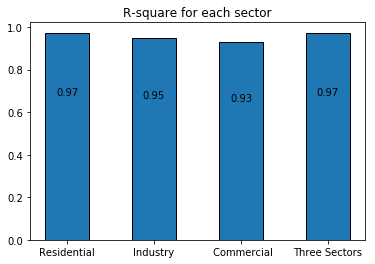

In [37]:
test_idxs = len(res_predict)
y_all_test = combine.iloc[-len(res_predict):]['Sale_ALL_no_OTH']
# over all prediction
all_predict = res_predict+ind_predict+com_predict
all_score = r2_score(y_all_test,all_predict)

x = ['Residential', 'Industry',' Commercial', 'Three Sectors']
y = [res_score,ind_score,com_score, all_score]
plt.bar(x,height=y, edgecolor ='black',width=0.5)

for i in range(len(y)):
        plt.text(s=f'{y[i].round(2)}',x=i, y=y[i].round(2)*0.7,horizontalalignment='center')
plt.title('R-square for each sector')    

**Model performance by state**

In [38]:
# analyzing the prediction result
data = combine.iloc[-len(res_predict):][['Year-Month','State','Sale_RES','Sale_IND','Sale_COM','Sale_ALL_no_OTH']]
data['res_predict'] = res_predict
data['ind_predict'] = ind_predict
data['com_predict'] = com_predict
data['all_predict'] = all_predict

In [39]:
score_by_state = []
for state in data['State'].unique():
    temp = data[data['State']==state]
    score = r2_score(temp['Sale_ALL_no_OTH'],temp['all_predict'])
    score_by_state.append([state,score])

In [40]:
# model r-square by state 
score_by_state = pd.DataFrame(score_by_state,columns=['State','Score']).sort_values('Score')

Text(0.5, 1.0, 'R-squared by state')

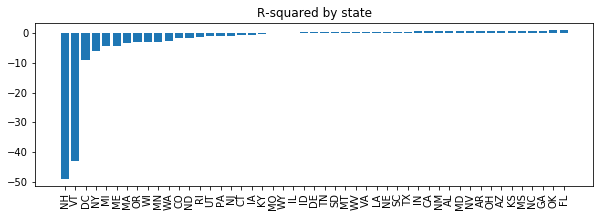

In [49]:
plt.figure(figsize=(10, 3))
plt.bar(score_by_state['State'],score_by_state['Score'])
_=plt.xticks(rotation=90)
plt.title('R-squared by state')

In [42]:
# select the three sates with best and worse prediction 
select_state = ['MS', 'NC', 'GA', 'DC','VT','NH']
data = data[data['State'].isin(select_state)]
data = data.set_index('Year-Month').loc['2014-07-01':]

Text(0.5, 0.98, 'Monthly Prediction by State')

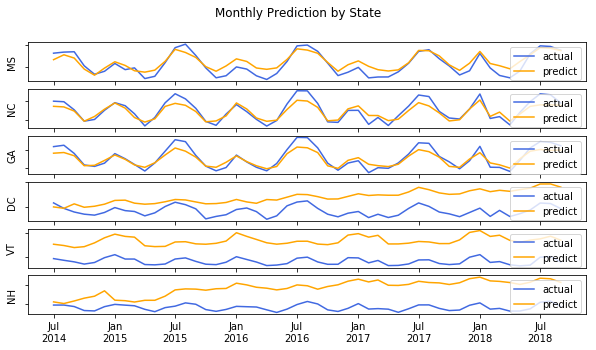

In [43]:
fig, ax = plt.subplots(6,1,figsize=(10, 5),sharex=True)

for i, state in enumerate(select_state):
    temp = data[data['State']==state]
    ax[i].plot(temp['Sale_ALL_no_OTH'],c='royalblue')
    ax[i].plot(temp['all_predict'],c='orange')
    ax[i].legend(['actual','predict'], loc='upper right')
    ax[i].axes.set_ylabel(state)
    ax[i].axes.set_yticklabels([])

ax[-1].xaxis.set_major_formatter(mdates.DateFormatter("%b\n%Y"))
fig.suptitle('Monthly Prediction by State')

In [46]:
state_location = pd.read_html('https://inkplant.com/code/state-latitudes-longitudes')[0]
state_location['State'] = state_location['State'].replace(to_replace=us_state_abbrev)
score_by_state = score_by_state.merge(state_location,on='State')

In [47]:
correct = score_by_state[score_by_state['Score']>0.5]
incorrect = score_by_state[score_by_state['Score']<=0.5]

In [50]:
# generate a map of model perfomance 
m = folium.Map(location=[40, -98], zoom_start=4, width=700, height=450)
 
# add marker one by one on the map
for i in range(0,len(correct)):
   folium.Circle(
      location=[correct.iloc[i]['Latitude'], correct.iloc[i]['Longitude']],
       popup=correct.iloc[i]['State'],
      radius=correct.iloc[i]['Score']*10000,
      color='royalblue',
      fill=True,
      fill_color='royalblue'
   ).add_to(m)


for i in range(0,len(correct)):
   folium.Circle(
      location=[incorrect.iloc[i]['Latitude'], incorrect.iloc[i]['Longitude']],
       popup=incorrect.iloc[i]['State'],
       radius= np.abs(incorrect.iloc[i]['Score'])*10000,
      color='crimson',
      fill=True,
      fill_color='crimson'
   ).add_to(m)

display(m)

![](https://github.com/worasom/energy_sale_rev/blob/master/plots/plot2.png)
In the second plot, I analyze the machine learning models performance. The prediction for each sector are added and computer the R-squared against the actual data. The overall R-squared is 0.97. However, when breaking down by the state. The model perform well on the southern state with high consumption and high population (blue). The model did very poorly on predicting the electricity consumption of the northern state, with the worst two states are New Hampshire and Vermont. I am working on improving the model performance on these states.